In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wandb -q
import wandb
from wandb.keras import WandbCallback

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

random_state=42

tf.random.set_seed(random_state)

# 1. Start a new run
wandb.init(project='trials-lstm', entity='covid19india')

# 2. Save model inputs and hyperparameters
config = wandb.config
config.random_state = random_state
config.columns = ["new_cases"]

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Major Project/data/world_cleaned_v4.csv")
print(df.columns, df.shape)

Index(['Unnamed: 0', 'Unnamed: 0_x', 'date', 'location', 'new_cases',
       'stringency_index', 'population', 'nomalized_new_cases', 'Unnamed: 0_y',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object') (24676, 15)


In [ ]:
columns_list = ['date', 'location', 'new_cases', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']
df = df.loc[:, columns_list]
df.head(5)

,date,location,new_cases,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-15,Argentina,11.0,-29.0,17.0,-44.0,-17.0,-10.0,9.0
1,2020-03-16,Argentina,11.0,-27.0,8.0,-39.0,-17.0,1.0,6.0
2,2020-03-17,Argentina,12.0,-41.0,-11.0,-54.0,-32.0,-12.0,11.0
3,2020-03-18,Argentina,11.0,-43.0,-11.0,-49.0,-35.0,-19.0,12.0
4,2020-03-19,Argentina,18.0,-42.0,5.0,-55.0,-35.0,-24.0,13.0


In [ ]:
# 7-day averaging
df_7 = pd.DataFrame(columns=columns_list)
for loc in df.location.unique():
  loc_df_7 = pd.DataFrame(columns=columns_list)
  loc_df = df[df.location==loc]
  loc_df.reset_index(drop=True, inplace=True)
  for col in columns_list:
    li=[]
    dts=[]
    if col=='date' or col=='location':
      continue
    for i in range(loc_df.shape[0]-7):
      li.append(np.mean(loc_df[col][i:i+7]))
      dts.append(loc_df["date"][i+6])
    loc_df_7[col] = li
    loc_df_7["location"] = loc
    loc_df_7.loc[:, "date"] = dts
  df_7 = pd.concat([df_7, loc_df_7], ignore_index=True)
print(df_7.shape)
df_7.reset_index(drop=True, inplace=True)
df_7.head(5)

(24242, 9)


,date,location,new_cases,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-21,Argentina,17.714286,-49.000000,-11.571429,-58.000000,-40.428571,-26.000000,15.428571
1,2020-03-22,Argentina,31.571429,-57.285714,-22.714286,-64.571429,-49.571429,-32.857143,18.000000
2,2020-03-23,Argentina,35.000000,-66.000000,-33.000000,-71.571429,-59.285714,-44.285714,21.714286
3,2020-03-24,Argentina,45.571429,-72.714286,-40.571429,-76.428571,-66.857143,-53.857143,24.571429
4,2020-03-25,Argentina,44.000000,-78.285714,-46.142857,-81.142857,-72.857143,-60.857143,26.857143


In [ ]:
# Data Preprocessing

ts_data = df_7

# Scale the data
scalers={}
for loc in ts_data.location.unique():
  for col in columns_list:
    if col=="date" or col=='location':
      continue
    if col=='new_cases':
      sc = MinMaxScaler(feature_range=(-1,1))
    else:
      sc = MinMaxScaler()
    ts_data.loc[ts_data[ts_data.location==loc].index, col] = sc.fit_transform(ts_data[ts_data.location==loc][col].values.reshape(-1,1))
    scalers["sc_"+loc+'_'+col] = sc

train_ts = ts_data.drop(index=ts_data[ts_data.location=="India"].index)
test_ts = ts_data[ts_data.location=="India"]
print(train_ts.shape, test_ts.shape)

(23851, 9) (391, 9)


In [ ]:
features_list = columns_list.copy()
features_list.remove('date')
features_list.remove('location')

In [ ]:
# The expected shape for a rnn is [batch, timesteps, features]. 
# Create the dataset

timesteps=331
features=len(columns_list)-2 # remove date and location
op_days = 60 # number of output days to predict
config.output_days=op_days
config.timesteps = timesteps
config.features = features
X_train = np.empty((0, timesteps, features))

for i, loc in enumerate(train_ts.location.unique()):
  loc_df = train_ts[train_ts.location==loc]
  for j in range(loc_df.shape[0]-timesteps-op_days+1):
    one_batch = np.expand_dims(loc_df[j:j+timesteps][features_list].values, axis=0)
    X_train = np.append(X_train, one_batch, axis=0)
config.batch = X_train.shape[0]
print(X_train.shape)

(61, 331, 7)


In [ ]:
# y_train
y_train = np.empty((0, op_days))
for i, loc in enumerate(train_ts.location.unique()):
  loc_df = train_ts[train_ts.location==loc]
  for j in range(loc_df.shape[0]-timesteps-op_days+1):
    one_batch = np.expand_dims(loc_df[j+timesteps:j+timesteps+op_days]["new_cases"].values, axis=0)
    y_train = np.append(y_train, one_batch, axis=0)
  # print(loc_df.shape, y_train.shape, j+1)
  # y_train[i] = train_ts[train_ts.location==loc]["new_cases"].iloc[-1]
print(y_train.shape)

(61, 60)


In [ ]:
# Similarly do for test data
"""To test with the covid19india dataset, uncomment below (can be used only when using a single feature - daily/new cases)"""
# custom_test_ts = pd.read_csv("/content/drive/MyDrive/Major Project/data/central_data/cleaned.csv")
# custom_test_ts = custom_test_ts.loc[:, ["Daily Confirmed"]]

# cts_7 = pd.DataFrame(columns=["Daily Confirmed"])
# # 7-day averaging
# li=[]
# for i in range(custom_test_ts.shape[0]-7):
#   li.append(np.mean(custom_test_ts["Daily Confirmed"][i:i+7]))
# cts_7["Daily Confirmed"] = li
# print(cts_7.shape)

# sc = MinMaxScaler()
# # Change the value below from custom_test_ts or cts_7 as required
# cts = sc.fit_transform(cts_7.values.reshape(-1, 1))
# test_ts = pd.DataFrame(cts[100:], columns=["new_cases"])

'To test with the covid19india dataset, uncomment below'

In [ ]:
config.test_num = 0

# Setup test dataset, the whole of India is to be used as test
X_test = np.empty((0, timesteps, features))
for j in range(test_ts.shape[0]-timesteps-op_days+1):
  one_batch = np.expand_dims(test_ts[j:j+timesteps][features_list].values, axis=0)
  X_test = np.append(X_test, one_batch, axis=0)

y_test = np.empty((0,op_days))
for j in range(test_ts.shape[0]-timesteps-op_days+1):
  one_batch = np.expand_dims(test_ts[j+timesteps:j+timesteps+op_days]["new_cases"].values, axis=0)
  y_test = np.append(y_test, one_batch, axis=0)
print(X_test.shape, y_test.shape)

(1, 331, 7) (1, 60)


In [ ]:
# Creating the model

model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(timesteps,features), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(128, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(128, return_sequences=False))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(op_days))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 331, 128)          69632     
_________________________________________________________________
dropout_6 (Dropout)          (None, 331, 128)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 331, 128)          131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 331, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)               

In [ ]:
# Compiling the model
opt=keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()])

In [ ]:
# 3. Log layer dimensions and metrics over time
epochs = 20
config.epochs = epochs
history = model.fit(X_train, y_train, epochs=epochs, callbacks=[WandbCallback()])

Epoch 1/20
2/2 [==============================] - 4s 99ms/step - loss: 0.4635 - root_mean_squared_error: 0.5444 - mean_absolute_error: 0.4635
Epoch 2/20
2/2 [==============================] - 0s 65ms/step - loss: 0.4552 - root_mean_squared_error: 0.5401 - mean_absolute_error: 0.4552
Epoch 3/20
2/2 [==============================] - 0s 64ms/step - loss: 0.4418 - root_mean_squared_error: 0.5262 - mean_absolute_error: 0.4418
Epoch 4/20
2/2 [==============================] - 0s 44ms/step - loss: 0.4425 - root_mean_squared_error: 0.5354 - mean_absolute_error: 0.4425
Epoch 5/20
2/2 [==============================] - 0s 43ms/step - loss: 0.4123 - root_mean_squared_error: 0.5009 - mean_absolute_error: 0.4123
Epoch 6/20
2/2 [==============================] - 0s 43ms/step - loss: 0.4098 - root_mean_squared_error: 0.4971 - mean_absolute_error: 0.4098
Epoch 7/20
2/2 [==============================] - 0s 42ms/step - loss: 0.4031 - root_mean_squared_error: 0.4967 - mean_absolute_error: 0.4031
Epoch 

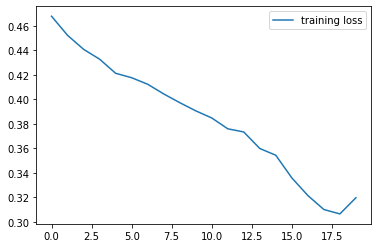

In [ ]:
# plot history
plt.plot(history.history['loss'], label='training loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred.shape

(1, 60)

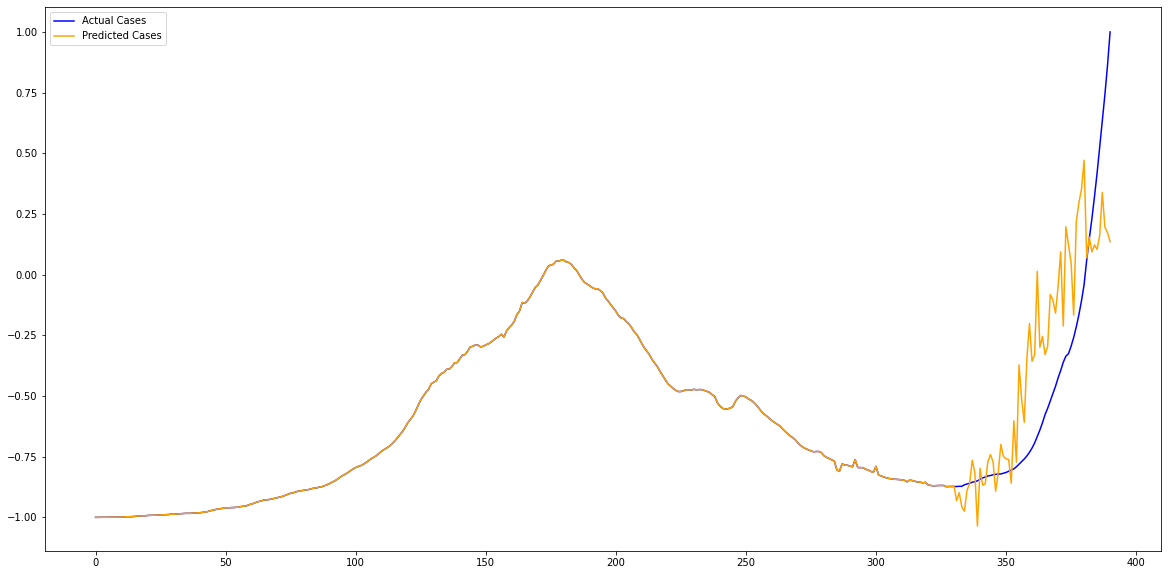

In [ ]:
# Plot scaled values
plt.figure(figsize=(20,10))
root = test_ts["new_cases"].iloc[:-y_test.shape[1]]
act = root.append(pd.Series(y_test.reshape(-1)), ignore_index=True)
pred = root.append(pd.Series(y_pred.reshape(-1)), ignore_index=True)
plt.plot(act, color='blue', label="Actual Cases")
plt.plot(pred, color='orange', label="Predicted Cases")
plt.legend()
wandb.log({"actual_vs_predicted": wandb.Image(plt)})
plt.show()

In [ ]:
"""In order to study the impact of mobility data, uncomment below"""
# train_ts_copy = train_ts.copy()
# test_ts_copy = test_ts.copy()
# for col in ['retail_and_recreation_percent_change_from_baseline',
#        'grocery_and_pharmacy_percent_change_from_baseline',
#        'parks_percent_change_from_baseline',
#        'transit_stations_percent_change_from_baseline',
#        'workplaces_percent_change_from_baseline',
#        'residential_percent_change_from_baseline']:
#        train_ts_copy[col] -= abs(train_ts_copy[col]*0.25)
#        test_ts_copy[col] -= abs(test_ts_copy[col]*0.25)

In [ ]:
"""In order to study the impact of mobility data, uncomment below"""
# X_train_copy = np.empty((0, timesteps, features))
# for i, loc in enumerate(train_ts_copy.location.unique()):
#   loc_df = train_ts_copy[train_ts_copy.location==loc]
#   for j in range(loc_df.shape[0]-timesteps-op_days+1):
#     one_batch = np.expand_dims(loc_df[j:j+timesteps][features_list].values, axis=0)
#     X_train_copy = np.append(X_train_copy, one_batch, axis=0)
# print(X_train_copy.shape)

# y_train_copy = np.empty((0, op_days))
# for i, loc in enumerate(train_ts_copy.location.unique()):
#   loc_df = train_ts_copy[train_ts_copy.location==loc]
#   for j in range(loc_df.shape[0]-timesteps-op_days+1):
#     one_batch = np.expand_dims(loc_df[j+timesteps:j+timesteps+op_days]["new_cases"].values, axis=0)
#     y_train_copy = np.append(y_train_copy, one_batch, axis=0)
# print(y_train_copy.shape)


# X_test_copy = np.empty((0, timesteps, features))
# for j in range(test_ts_copy.shape[0]-timesteps-op_days+1):
#   one_batch = np.expand_dims(test_ts_copy[j:j+timesteps][features_list].values, axis=0)
#   X_test_copy = np.append(X_test_copy, one_batch, axis=0)

# y_test_copy = np.empty((0,op_days))
# for j in range(test_ts_copy.shape[0]-timesteps-op_days+1):
#   one_batch = np.expand_dims(test_ts_copy[j+timesteps:j+timesteps+op_days]["new_cases"].values, axis=0)
#   y_test_copy = np.append(y_test_copy, one_batch, axis=0)

# print(X_test_copy.shape, y_test_copy.shape)

(61, 331, 7)
(61, 60)
(1, 331, 7) (1, 60)


Error: ignored

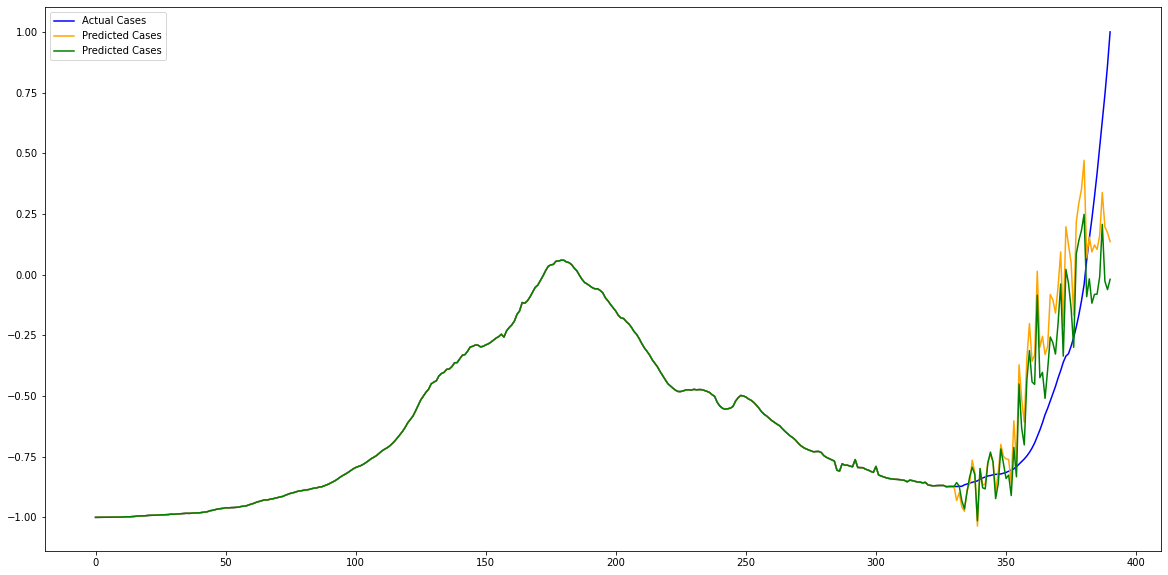

In [ ]:
"""In order to study the impact of mobility data, uncomment below"""
# plt.figure(figsize=(20,10))
# root = test_ts["new_cases"].iloc[:-y_test.shape[1]]
# act = root.append(pd.Series(y_test.reshape(-1)), ignore_index=True)
# pred = root.append(pd.Series(y_pred.reshape(-1)), ignore_index=True)
# impact = root.append(pd.Series(model.predict(X_test_copy).reshape(-1)), ignore_index=True)
# plt.plot(act, color='blue', label="Actual Cases")
# plt.plot(pred, color='orange', label="Predicted Cases")
# plt.plot(impact, color='green', label="Predicted Cases")
# plt.legend()
# wandb.log({"impact of lockdown": wandb.Image(plt)})
# plt.show()

In [ ]:
wandb.finish()

epoch,19
loss,0.31965
root_mean_squared_error,0.41547
mean_absolute_error,0.31965
_runtime,63
_timestamp,1619798172
_step,20


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▇▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁▁▂
root_mean_squared_error,█▇▇▇▆▆▆▆▅▅▅▅▄▃▃▂▂▁▁▂
mean_absolute_error,█▇▇▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁▁▂
_runtime,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂█
_timestamp,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
